In [1]:
!wget https://zenodo.org/record/3697452/files/LabPicsV1.zip?download=1

--2022-10-22 09:00:02--  https://zenodo.org/record/3697452/files/LabPicsV1.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.184.117.155
Connecting to zenodo.org (zenodo.org)|188.184.117.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2960213543 (2.8G) [application/octet-stream]
Saving to: ‘LabPicsV1.zip?download=1’

LabPicsV1.zip?downl 100%[===================>]   2.76G  23.6MB/s    in 2m 4s   

2022-10-22 09:02:09 (22.7 MB/s) - ‘LabPicsV1.zip?download=1’ saved [2960213543/2960213543]



In [2]:
!unzip 'LabPicsV1.zip?download=1' 

Streaming output truncated to the last 5000 lines.
  inflating: LabPicsV1/Simple/Train/Semantic/2_V Label/IMG_20181213_223510.png  
  inflating: LabPicsV1/Simple/Train/Semantic/2_V Label/IMG_20181213_223603.png  
  inflating: LabPicsV1/Simple/Train/Semantic/2_V Label/IMG_20181213_223609.png  
  inflating: LabPicsV1/Simple/Train/Semantic/2_V Label/IMG_20181213_223616.png  
  inflating: LabPicsV1/Simple/Train/Semantic/2_V Label/IMG_20181213_223623.png  
  inflating: LabPicsV1/Simple/Train/Semantic/2_V Label/IMG_20181219_184823.png  
  inflating: LabPicsV1/Simple/Train/Semantic/2_V Label/IMG_20181219_184825.png  
  inflating: LabPicsV1/Simple/Train/Semantic/2_V Label/IMG_20181219_204704.png  
  inflating: LabPicsV1/Simple/Train/Semantic/2_V Label/IMG_20181225_231505.png  
  inflating: LabPicsV1/Simple/Train/Semantic/2_V Label/IMG_20181225_231509.png  
  inflating: LabPicsV1/Simple/Train/Semantic/2_V Label/IMG_20181226_184458.png  
  inflating: LabPicsV1/Simple/Train/Semantic/2_V Label/IMG

In [3]:
import os
import numpy as np
import cv2
import torchvision.models.segmentation
import torch
import torchvision.transforms as tf
Learning_Rate=1e-5
width=height=800 # image width and height
batchSize=3

In [4]:
TrainFolder="LabPicsV1/Simple/Train/"
ListImages=os.listdir(os.path.join(TrainFolder, "Image")) 

In [5]:
transformImg=tf.Compose([tf.ToPILImage(),tf.Resize((height,width)), tf.ToTensor(),tf.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
transformAnn=tf.Compose([tf.ToPILImage(),tf.Resize((height,width)), tf.ToTensor()])

In [6]:
Learning_Rate=1e-5
width=height=800 # image width and height
batchSize=3


In [7]:
def ReadRandomImage(): 
  idx=np.random.randint(0,len(ListImages)) # Pick random image 
  Img=cv2.imread(os.path.join(TrainFolder, "Image",ListImages[idx]))
  Filled =  cv2.imread(os.path.join(TrainFolder,   "Semantic/16_Filled", ListImages[idx].replace("jpg","png")),0)       
 
  Vessel =  cv2.imread(os.path.join(TrainFolder, "Semantic/1_Vessel", ListImages[idx].replace("jpg","png")),0)
  AnnMap = np.zeros(Img.shape[0:2],np.float32) # Segmentation map  
  if Vessel is not None:  AnnMap[ Vessel == 1 ] = 1    
  if Filled is not None:  AnnMap[ Filled  == 1 ] = 2
  Img=transformImg(Img)
  AnnMap=transformAnn(AnnMap)
  return Img,AnnMap

In [8]:
idx = np.random.randint(0,len(ListImages)) # Pick random image
Img = cv2.imread(os.path.join(TrainFolder, "Image",ListImages[idx]))

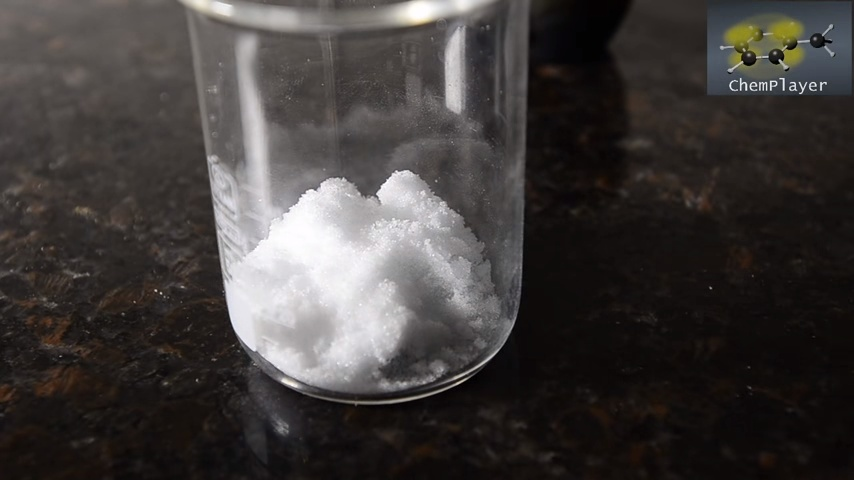

In [9]:
from google.colab.patches import cv2_imshow
cv2_imshow(Img)

In [10]:
Filled =  cv2.imread(os.path.join(TrainFolder,   "Semantic/16_Filled", ListImages[idx].replace("jpg","png")),0)       
 
Vessel =  cv2.imread(os.path.join(TrainFolder, "Semantic/1_Vessel", ListImages[idx].replace("jpg","png")),0)

In [11]:
AnnMap = np.zeros(Img.shape[0:2],np.float32)

In [12]:
if Vessel is not None:  AnnMap[ Vessel == 1 ] = 1    
if Filled is not None:  AnnMap[ Filled  == 1 ] = 2 

In [13]:
Img=transformImg(Img)
AnnMap=transformAnn(AnnMap)

In [14]:
def LoadBatch(): # Load batch of images
    images = torch.zeros([batchSize,3,height,width])
    ann = torch.zeros([batchSize, height, width])
    
    for i in range(batchSize):
        images[i],ann[i]=ReadRandomImage()
    
    return images, ann

In [15]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
Net = torchvision.models.segmentation.deeplabv3_resnet50(pretrained=True)
Net.classifier[4] = torch.nn.Conv2d(256, 3, kernel_size=(1, 1), stride=(1, 1)) # Change final layer to 3 classes
Net=Net.to(device)
optimizer=torch.optim.Adam(params=Net.parameters(),lr=Learning_Rate) # Create adam optimizer

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth


  0%|          | 0.00/161M [00:00<?, ?B/s]

In [ ]:
for itr in range(10000): # Training loop
   images,ann=LoadBatch() # Load taining batch
   images=torch.autograd.Variable(images,requires_grad=False).to(device) # Load image
   ann = torch.autograd.Variable(ann, requires_grad=False).to(device) # Load annotation
   Pred=Net(images)['out'] # make prediction
   Net.zero_grad()
   criterion = torch.nn.CrossEntropyLoss() # Set loss function
   Loss=criterion(Pred,ann.long()) # Calculate cross entropy loss
   Loss.backward() # Backpropogate loss
   optimizer.step() # Apply gradient descent change to weight
   seg = torch.argmax(Pred[0], 0).cpu().detach().numpy()  # Get  prediction classes
   print(itr,") Loss=",Loss.data.cpu().numpy())
   if itr % 1000 == 0: #Save model weight once every 60k steps permenant file
        print("Saving Model" +str(itr) + ".torch")
        torch.save(Net.state_dict(),   str(itr) + ".torch")

0 ) Loss= 1.1312988
Saving Model0.torch
1 ) Loss= 1.1166234
2 ) Loss= 1.1755925
3 ) Loss= 1.1449212
4 ) Loss= 1.0732129
5 ) Loss= 1.1352866
6 ) Loss= 1.0953239
7 ) Loss= 1.0117297
8 ) Loss= 1.0974108
9 ) Loss= 1.095947
10 ) Loss= 1.046277
11 ) Loss= 1.1013173
12 ) Loss= 1.0781378
13 ) Loss= 1.0514889
14 ) Loss= 1.0448043
15 ) Loss= 1.075544
16 ) Loss= 1.0095987
17 ) Loss= 1.038263
18 ) Loss= 1.0499274
19 ) Loss= 1.0232319
20 ) Loss= 1.0352669
21 ) Loss= 1.0544026
22 ) Loss= 1.0814198
23 ) Loss= 1.0039102
24 ) Loss= 1.0920327
25 ) Loss= 1.0196259
26 ) Loss= 1.0441302
27 ) Loss= 0.99536955
28 ) Loss= 1.0335671
29 ) Loss= 0.9941785
30 ) Loss= 1.0356842
31 ) Loss= 0.9445441
32 ) Loss= 1.0582863
33 ) Loss= 1.0507225
34 ) Loss= 0.91840047
35 ) Loss= 0.93585646
36 ) Loss= 1.0334421
37 ) Loss= 0.9808915
38 ) Loss= 0.9752232
39 ) Loss= 0.92458665
40 ) Loss= 0.9938132
41 ) Loss= 1.0571033
42 ) Loss= 0.95894855
43 ) Loss= 0.9558297
44 ) Loss= 0.98126876
45 ) Loss= 0.9548649
46 ) Loss= 0.96446145


In [2]:
import cv2
import torchvision.models.segmentation
import torch
import torchvision.transforms as tf
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth


  0%|          | 0.00/161M [00:00<?, ?B/s]

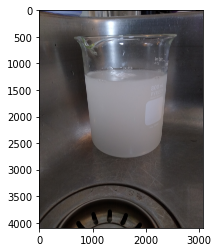

In [3]:
modelPath = "1000.torch"  # Path to trained model
imagePath = "test.jpg"  # Test image
height=width=800
transformImg = tf.Compose([tf.ToPILImage(), tf.Resize((height, width)), tf.ToTensor(),tf.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))])  # tf.Resize((300,600)),tf.RandomRotation(145)])#

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')  # Check if there is GPU if not set trainning to CPU (very slow)
Net = torchvision.models.segmentation.deeplabv3_resnet50(pretrained=True)  # Load net
Net.classifier[4] = torch.nn.Conv2d(256, 3, kernel_size=(1, 1), stride=(1, 1))  # Change final layer to 3 classes
Net = Net.to(device)  # Set net to GPU or CPU
Net.load_state_dict(torch.load(modelPath)) # Load trained model
Net.eval() # Set to evaluation mode
Img = cv2.imread(imagePath) # load test image
height_orgin , widh_orgin ,d = Img.shape # Get image original size 
plt.imshow(Img[:,:,::-1])  # Show image
plt.show()


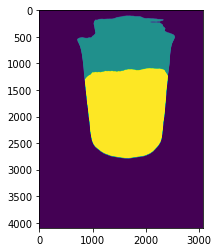

In [4]:
Img = transformImg(Img)  # Transform to pytorch
Img = torch.autograd.Variable(Img, requires_grad=False).to(device).unsqueeze(0)
with torch.no_grad():
    Prd = Net(Img)['out']  # Run net
Prd = tf.Resize((height_orgin,widh_orgin))(Prd[0]) # Resize to origninal size
seg = torch.argmax(Prd, 0).cpu().detach().numpy()  # Get  prediction classes
plt.imshow(seg)  # display image
plt.show()